In [1]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def get_mnist_loaders(batch_size=32):
  transform = transforms.ToTensor()
  train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)

  test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
  return train_loader, test_loader

In [2]:
import matplotlib.pyplot as plt # For plotting and displaying images
def visualize_batch(batch_size=16):
  # Load a mini-batch of training data
  train_loader, _ = get_mnist_loaders(batch_size)
  images, labels = next(iter(train_loader)) # Get the first batch

  # Create a horizontal grid of images
  plt.figure(figsize=(10, 4))
  for i in range(batch_size):
    plt.subplot(2, batch_size // 2, i + 1) # 2 rows, batch_size/2 columns
    plt.imshow(images[i][0], cmap='gray') # Show the image (channel 0 since MNIST is grayscale)
    plt.title(f"Label: {labels[i].item()}")
    plt.axis('off')
  plt.tight_layout()
  plt.show()

100%|██████████| 9.91M/9.91M [00:00<00:00, 55.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.63MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.1MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.81MB/s]


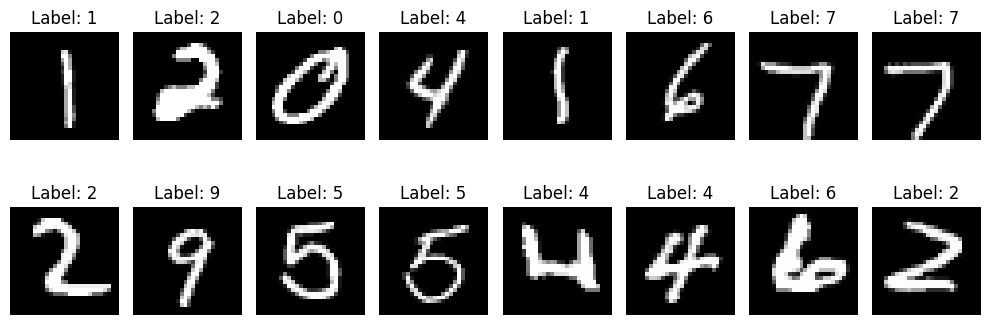

In [3]:
visualize_batch()

In [4]:
train_loader, test_loader = get_mnist_loaders()

In [5]:
import torch.nn as nn
import torch
class LSTMCell(nn.Module):
  def __init__(self, input_size, hidden_size):
    super().__init__()

    self.x_t = nn.Linear(input_size, hidden_size)
    self.a_t = nn.Linear(hidden_size, hidden_size)

    # Update gate params
    self.x_t_u = nn.Linear(input_size, hidden_size)
    self.a_t_u = nn.Linear(hidden_size, hidden_size)

    # Forget gate params
    self.x_t_f = nn.Linear(input_size, hidden_size)
    self.a_t_f = nn.Linear(hidden_size, hidden_size)

    # Output gate params
    self.x_t_o = nn.Linear(input_size, hidden_size)
    self.a_t_o = nn.Linear(hidden_size, hidden_size)
  def forward(self, x, a_t_prev, c_t_prev):
    gamma_u = torch.sigmoid(self.x_t_u(x) + self.a_t_u(a_t_prev)) # Update gate
    gamma_f = torch.sigmoid(self.x_t_f(x) + self.a_t_f(a_t_prev)) # forget gate
    gamma_o = torch.sigmoid(self.x_t_o(x) + self.a_t_o(a_t_prev)) # output gate

    c_t_tilde = torch.tanh(self.x_t(x) + self.a_t(a_t_prev))

    c_t = gamma_u * c_t_tilde + gamma_f * c_t_prev

    a_t = gamma_o * torch.tanh(c_t)

    return a_t, c_t

In [6]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, LSTMCell=LSTMCell):
    super().__init__()
    self.hidden_size = hidden_size
    self.LSTMCell = LSTMCell(input_size, hidden_size)

  def forward(self, x):
    # Using batch first [batch_size, seq_len, input_size]

    output = []

    batch_size, seq_len, _ = x.shape

    a_t = torch.zeros(batch_size, self.hidden_size).to(x.device)
    c_t = torch.zeros(batch_size, self.hidden_size).to(x.device)

    for i in range(seq_len):
      a_t, c_t = self.LSTMCell(x[:, i, :], a_t, c_t)
      output.append(a_t)
    return torch.stack(output, dim=1), (a_t, c_t)



In [7]:
class DigitClassification(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super().__init__()
    self.LSTM = LSTM(input_size, hidden_size)
    self.classifier = nn.Linear(hidden_size, output_size)
  def forward(self, x):
    x = x.view(-1, 28, 28)
    _, (a_t, c_t) = self.LSTM(x)
    out = self.classifier(a_t)
    return out

In [8]:
model = DigitClassification(input_size=28, hidden_size=128, output_size=10)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

DigitClassification(
  (LSTM): LSTM(
    (LSTMCell): LSTMCell(
      (x_t): Linear(in_features=28, out_features=128, bias=True)
      (a_t): Linear(in_features=128, out_features=128, bias=True)
      (x_t_u): Linear(in_features=28, out_features=128, bias=True)
      (a_t_u): Linear(in_features=128, out_features=128, bias=True)
      (x_t_f): Linear(in_features=28, out_features=128, bias=True)
      (a_t_f): Linear(in_features=128, out_features=128, bias=True)
      (x_t_o): Linear(in_features=28, out_features=128, bias=True)
      (a_t_o): Linear(in_features=128, out_features=128, bias=True)
    )
  )
  (classifier): Linear(in_features=128, out_features=10, bias=True)
)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [10]:
epochs = 10
for epoch in range(epochs):
  running_loss = 0.0
  for images, targets in train_loader:
    images = images.to(device)
    targets = targets.to(device)

    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")


Epoch 1/10, Loss: 0.35905330972671506
Epoch 2/10, Loss: 0.11276032264816264
Epoch 3/10, Loss: 0.07675111181475222
Epoch 4/10, Loss: 0.05976210466306656
Epoch 5/10, Loss: 0.04733304212416212
Epoch 6/10, Loss: 0.03894993536525095
Epoch 7/10, Loss: 0.033846180220491566
Epoch 8/10, Loss: 0.029500325580965728
Epoch 9/10, Loss: 0.02503393310982889
Epoch 10/10, Loss: 0.02296483846361904


In [11]:
# Test the accuracy of the model
model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for images, target in test_loader:
    images = images.to(device)
    target = target.to(device)

    output = model.forward(images)

    _, topk = output.topk(1, dim=1)

    topk = topk.squeeze(1)

    correct += (topk == target).sum()

    total += target.size(0)

  print(f"Accuracy: {100*correct/total}%")

Accuracy: 98.7699966430664%


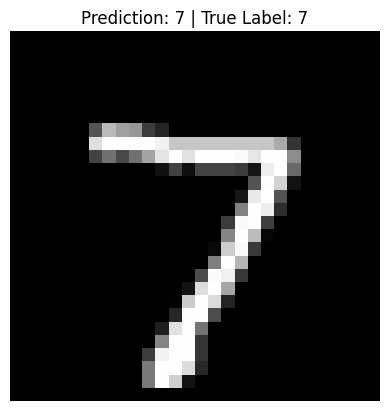

In [12]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

# Set model to eval mode
model.eval()

# Get one batch from test_loader
images, labels = next(iter(test_loader))

# Pick one sample
index = 0
image = images[index].to(device).unsqueeze(0)  # Add batch dimension
label = labels[index]

# Make prediction
with torch.no_grad():
    output = model(image)
    _, pred = output.topk(1, dim=1)
    pred = pred.item()

# Show image
plt.imshow(TF.to_pil_image(images[index]), cmap="gray")
plt.title(f"Prediction: {pred} | True Label: {label.item()}")
plt.axis('off')
plt.show()